In [2]:
# Otimizar sklearn
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


---


# Baixar dataset

In [3]:
# !pip install kaggle wordcloud nltk
# !echo '{"username":"pauloubirajara","key":"4a5d061c2eade0bf96665e1fb7a8fd28"}' > /root/.kaggle/kaggle.json
# !sleep 3
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d brobear1995/rss-feed-topic-classifier --force
# !unzip -o -u rss-feed-topic-classifier.zip

---


# Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from nltk import download
from nltk.tokenize import word_tokenize

# Filtrar stopwords
from nltk.corpus import stopwords
from string import punctuation
download('stopwords')
download('punkt')

STOPWORDS = stopwords.words('english')
STOPWORDS.extend(punctuation)
# STOPWORDS.extend(['\\'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Obter uma representação vetorial a partir de um texto
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score, cross_val_predict

# Balancear dados
from imblearn.over_sampling import SMOTE

---


# Carregar dados

In [6]:
df_dados = pd\
  .read_csv('topic_classifier.csv')\
  .astype('str')\
  .sample(frac=1)
print(df_dados['Topic'].value_counts())
df_dados

Entertainment           2028
News                    1106
Sprituality              678
Machine Learning         663
Software Development     580
Independence             392
Science                  318
Wellness                 106
Name: Topic, dtype: int64


,title,c1body,Topic
280,R to @narendramodi: Makar Sankranti is marked ...,Makar Sankranti is marked with enthusiasm in s...,News
3306,"Tim Berners Lee wants to put you in a pod, a w...",You can find out more about Sir Berners-Lee's ...,Software Development
1351,Underspecification Presents Challenges for Cre...,#ai #research #machinelearning Deep Learning m...,Machine Learning
1554,#94 – Ilya Sutskever: Deep Learning,"Ilya Sutskever is the co-founder of OpenAI, is...",Machine Learning
3361,Stack Exchange Podcast #71 - A Bunch of Bald Yaks,Stack Exchange Podcast #71 - A Bunch of Bald Y...,Software Development
...,...,...,...
1044,How One Supernova Measured The Universe,In 2015 astronomers successfully predicted the...,Science
5358,The beautiful Lake Tahoe,[link] [comments],Entertainment
1546,#125 – Ryan Hall: Martial Arts and the Philoso...,"Ryan Hall is a jiu jitsu black belt, UFC fight...",Machine Learning
4767,Care for those who care for you (credit: how.how),[link] [comments],Entertainment


In [7]:
entertainment = df_dados[df_dados['Topic'] == 'Entertainment'].sample(frac=1).iloc[:678]
news = df_dados[df_dados['Topic'] == 'News'].sample(frac=1).iloc[:678]
df_dados_2 = df_dados[df_dados['Topic'] != 'Entertainment']
df_dados_2 = df_dados_2[df_dados_2['Topic'] != 'News']
df_dados_2 = pd.concat([df_dados_2, news, entertainment])
y_true = df_dados['Topic']
X = df_dados.drop(columns=['Topic'])

---


In [8]:
def TFIDF(corpus, as_frame=True):
  vectorizer = TfidfVectorizer(
    stop_words=STOPWORDS,
    lowercase=True,
    # max_features=10000,
  )
  # Colunas variam até 36351 features se não limitadas
  tfidf = vectorizer.fit_transform(corpus)
  
  if as_frame:
    try:
      df_tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf, columns=vectorizer.get_feature_names_out())
    except:
      df_tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf, columns=vectorizer.get_feature_names())
    return df_tfidf
  
  return tfidf

In [9]:
def BAG_OF_WORDS(corpus, as_frame=True):
  count_vectorizer = CountVectorizer(
    lowercase=True, 
    # max_features=10000,
    stop_words=STOPWORDS
  )
  bow = count_vectorizer.fit_transform(corpus)
  
  if as_frame:
    try:
      df_bow = pd.DataFrame.sparse.from_spmatrix(bow, columns=count_vectorizer.get_feature_names_out())
    except:
      df_bow = pd.DataFrame.sparse.from_spmatrix(bow, columns=count_vectorizer.get_feature_names())
    
    return df_bow
  
  return bow

In [10]:
# sm = SMOTE()

# def get_smote_as_dataframe(features, target, representation_method):
#   smote = sm.fit_resample(
#     representation_method(features),
#     target
#   )
#   # print(smote)
#   # print(len(smote))
#   return pd.concat([*smote], axis=1)

In [11]:
def show_report(y_true, y_pred, labels):
	print(classification_report(y_true, y_pred, target_names=labels))

In [12]:
def logistic_regression():
  return LogisticRegression()
  
def random_forest():
  return RandomForestClassifier()

def decision_tree():
  return DecisionTreeClassifier()

---


In [13]:
# !lscpu | grep "CPU(s)"

In [14]:
features = TFIDF(X['title'] + X['c1body'])
topics = sorted(y_true.unique())

---


# Logistic Regression + TFIDF (Sem smote)

In [ ]:
scores = cross_val_score(logistic_regression(), features, y_true, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(logistic_regression(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(logistic_regression(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

In [ ]:
y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Regressão Logística - TFIDF')
plt.show()

---


# Random Forest + TFIDF (Sem smote)

In [25]:
scores = cross_val_score(random_forest(), features.values, y_true, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(random_forest(), features.values, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

0.8557368262466827
                      precision    recall  f1-score   support

       Entertainment       0.79      0.95      0.86      2028
        Independence       0.87      0.72      0.79       392
    Machine Learning       0.90      0.80      0.85       663
                News       0.85      0.84      0.85      1106
             Science       0.91      0.39      0.55       318
Software Development       0.95      0.94      0.94       580
         Sprituality       0.94      0.87      0.90       678
            Wellness       1.00      0.74      0.85       106

            accuracy                           0.85      5871
           macro avg       0.90      0.78      0.82      5871
        weighted avg       0.86      0.85      0.85      5871



In [29]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(random_forest(), features.values, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(random_forest(), features.values, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

Entertainment x Não Entertainment
0.901041268296075
                   precision    recall  f1-score   support

    Entertainment       0.87      0.84      0.85      2028
Não Entertainment       0.92      0.93      0.92      3843

         accuracy                           0.90      5871
        macro avg       0.89      0.89      0.89      5871
     weighted avg       0.90      0.90      0.90      5871


Independence x Não Independence
0.95571625583794
                  precision    recall  f1-score   support

    Independence       0.98      0.33      0.50       392
Não Independence       0.95      1.00      0.98      5479

        accuracy                           0.96      5871
       macro avg       0.97      0.67      0.74      5871
    weighted avg       0.96      0.96      0.94      5871


Machine Learning x Não Machine Learning
0.9552040236878396
                      precision    recall  f1-score   support

    Machine Learning       0.99      0.61      0.76       663
Não M

[[1935    7    6   65    2    2   11    0]
 [  81  281   13    7    3    4    3    0]
 [  56   26  530   31    3    8    9    0]
 [ 151    2    7  932    1    9    4    0]
 [ 144    7   20   13  124    3    7    0]
 [  11    0    9   13    2  543    2    0]
 [  71    0    1   14    2    1  589    0]
 [   2    0    1   20    0    1    4   78]]


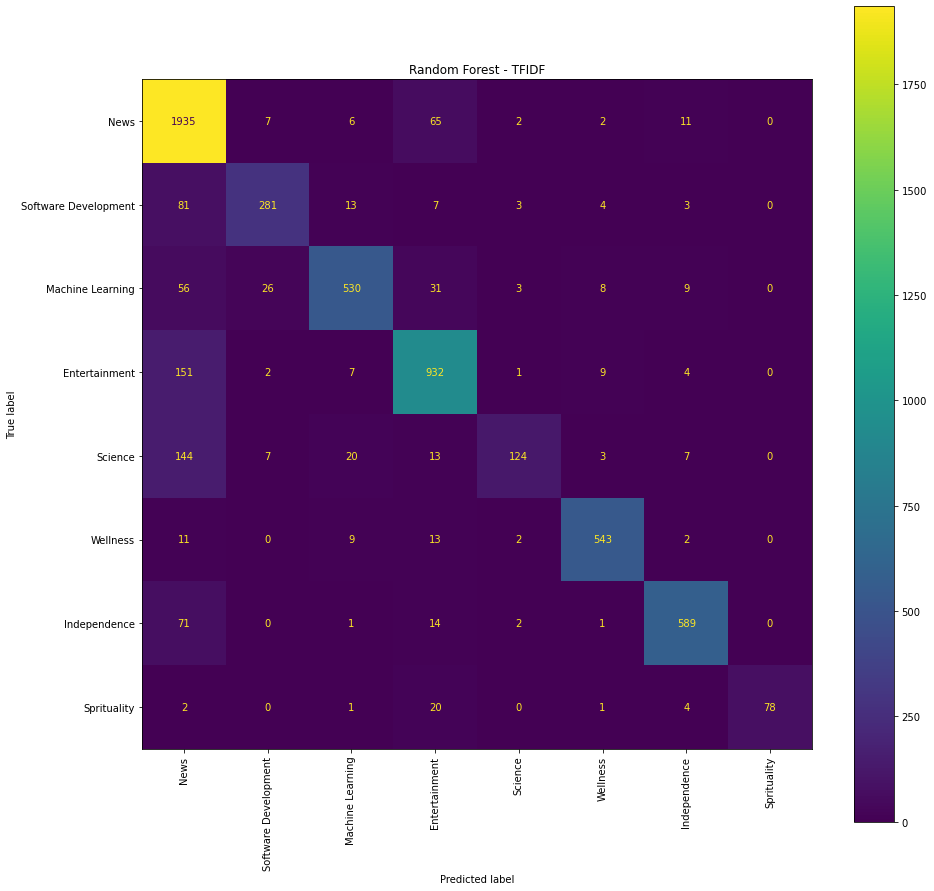

In [26]:
# y_pred = cross_val_predict(random_forest(), features.values, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Random Forest - TFIDF')
plt.show()

---


# Decision Tree + TFIDF (Sem smote)

In [21]:
scores = cross_val_score(decision_tree(), features, y_true, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(decision_tree(), features, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

0.7988463187660072
                      precision    recall  f1-score   support

       Entertainment       0.83      0.89      0.86      2028
        Independence       0.71      0.71      0.71       392
    Machine Learning       0.74      0.69      0.71       663
                News       0.81      0.82      0.82      1106
             Science       0.50      0.38      0.43       318
Software Development       0.86      0.83      0.85       580
         Sprituality       0.84      0.82      0.83       678
            Wellness       0.80      0.70      0.74       106

            accuracy                           0.80      5871
           macro avg       0.76      0.73      0.74      5871
        weighted avg       0.79      0.80      0.79      5871



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(decision_tree(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(decision_tree(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[1803   37   34   80   40   11   22    1]
 [  49  280   22   20   14    6    1    0]
 [  34   50  458   41   21   27   26    6]
 [ 113    9   21  910   19   13   19    2]
 [ 107   15   29   18  121    9   17    2]
 [  13    1   34   19    9  484   16    4]
 [  45    2   22   27   14    8  556    4]
 [   3    0    3   11    4    6    5   74]]


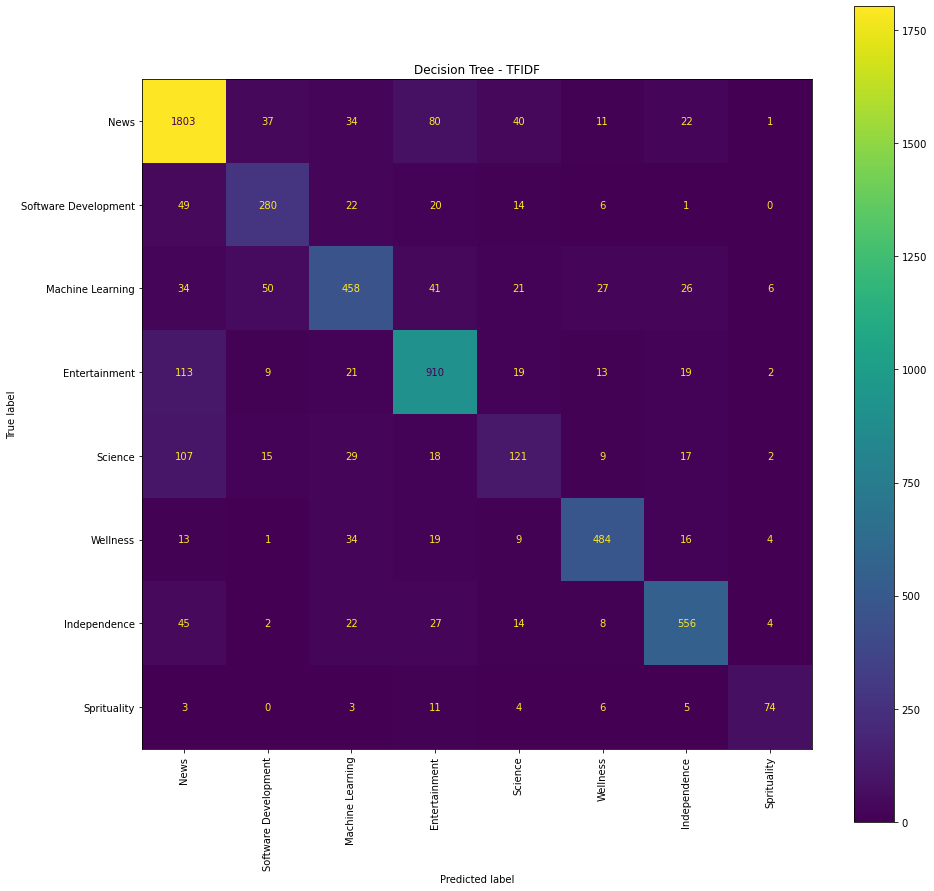

In [22]:
# y_pred = cross_val_predict(decision_tree(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Decision Tree - TFIDF')
plt.show()

------
# Resultados

| Representação Vetorial | Modelo | Score |
| --- | --- | --- |
| TFIDF (Sem smote) | Logistic Regression | 82.54 % |
| TFIDF (Sem smote) | Random Forest | 85.36 % |
| TFIDF (Sem smote) | Decision Tree | 79.88 % |
| 
| TFIDF (Com smote) | Logistic Regression | |
| TFIDF (Com smote) | Random Forest | |
| TFIDF (Com smote) | Decision Tree | |


| Representação Vetorial | Modelo | Score |
| --- | --- | --- |
| BOW (Sem smote) | Logistic Regression | |
| BOW (Sem smote) | Random Forest | |
| BOW (Sem smote) | Decision Tree | |
| |
| BOW (Com smote) | Logistic Regression | |
| BOW (Com smote) | Random Forest | |
| BOW (Com smote) | Decision Tree | |


---
# Resultados rodando um tópico por vez

# Logistic Regression (Sem SMOTE)

## Geral
### 82.54 %

|                Topic      | precision   | recall | f1-score  | support |
|                ---      | ---   | --- | ---  | --- |
|        Entertainment      | 0.75     | 0.97     | 0.85     | 2028 |
|         Independence      | 0.92     | 0.62     | 0.74      | 392 |
|     Machine Learning      | 0.91     | 0.79     | 0.85      | 663 |
|                 News      | 0.79     | 0.81     | 0.80     | 1106 |
|              Science      | 0.96     | 0.34     | 0.50      | 318 |
| Software Development      | 0.98     | 0.88     | 0.93      | 580 |
|          Sprituality      | 0.96     | 0.77     | 0.85      | 678 |
|             Wellness      | 1.00     | 0.66     | 0.80      | 106 |


            accuracy                           0.83      5871 
           macro avg       0.91      0.73      0.79      5871 
        weighted avg       0.85      0.83      0.82      5871 

## Entertainment x Não Entertainment
### 89.79 %

| Topic | precision   | recall | f1-score  | support |
| --- | --- | ---  | --- |--- |
|     Entertainment      | 0.89     | 0.81     | 0.85     | 2028 |
| Não Entertainment      | 0.90     | 0.95     | 0.92     | 3843 |

         accuracy                            0.90      5871 
        macro avg        0.90      0.88      0.88      5871   
     weighted avg        0.90      0.90      0.90      5871 

## Independence x Não Independence
### 94.82 %

|  Topic                 | precision   | recall | f1-score  | support |
| ---                  | ---   | --- | -------  | --- |
|     Independence      | 0.93     | 0.24     | 0.38      | 392 |
| Não Independence      | 0.95     | 1.00     | 0.97     | 5479 |

        accuracy                           0.95      5871 
       macro avg       0.94      0.62      0.68      5871 
    weighted avg       0.95      0.95      0.93      5871 

## Machine Learning x Não Machine Learning
### 94.78 %

| Topic | precision   | recall | f1-score  | support |
|  ---                     | ---   | --- | -------  | --- |
|     Machine Learning      | 0.99     | 0.55     | 0.70      | 663 |
| Não Machine Learning      | 0.95     | 1.00     | 0.97     | 5208 |

             accuracy                           0.95      5871 
            macro avg       0.97      0.77      0.84      5871 
         weighted avg       0.95      0.95      0.94      5871 

## News x Não News
### 88.82 %

| Topic             | precision   | recall | f1-score  | support |
| ---             | ---   | --- | -------  | --- |
|         News      | 1.00     | 0.41     | 0.58     | 1106 |
|     Não News      | 0.88     | 1.00     | 0.94     | 4765 |

           accuracy                           0.89      5871
          macro avg       0.94      0.70      0.76      5871
       weighted avg       0.90      0.89      0.87      5871

## Science x Não Science
### 95.00 %

| Topic             | precision   | recall | f1-score  | support |
| ---             | ---   | --- | -------  | --- |
|      Science      | 0.95     | 1.00     | 0.97     | 5553 |
|  Não Science      | 1.00     | 0.08     | 0.15      | 318 |

            accuracy                           0.95      5871
           macro avg       0.97      0.54      0.56      5871
        weighted avg       0.95      0.95      0.93      5871

## Software Development x Não Software Development
### 95.67 %

| Topic                         | precision   | recall | f1-score  | support |
| ---                         | ---   | --- | -------  | --- |
|     Software Development      | 0.95     | 1.00     | 0.98     | 5291 |
| Não Software Development      | 1.00     | 0.56     | 0.72      | 580 |

                accuracy                           0.96      5871
               macro avg       0.98      0.78      0.85      5871
            weighted avg       0.96      0.96      0.95      5871

## Sprituality x Não Sprituality
### 94.07 %

| Topic                | precision   | recall | f1-score  | support |
| ---                | ---   | --- | -------  | --- |
|     Sprituality      | 0.94     | 1.00     | 0.97     | 5193 |
| Não Sprituality      | 0.99     | 0.49     | 0.66      | 678 |

          accuracy                           0.94      5871
         macro avg       0.96      0.75      0.81      5871
      weighted avg       0.94      0.94      0.93      5871

## Wellness x Não Wellness
### 98.79 %

| Topic             | precision   | recall | f1-score  | support |
| ---             | ---   | --- | -------  | --- |
|     Wellness      | 0.99     | 1.00     | 0.99     | 5765 |
| Não Wellness      | 1.00     | 0.33     | 0.50      | 106 |

            accuracy                           0.99      5871
           macro avg       0.99      0.67      0.75      5871
        weighted avg       0.99      0.99      0.98      5871

# Random Forest (Sem SMOTE)

## Geral
### 85.57 %

| Topic                     | precision   | recall | f1-score  | support |
| ---                     | ---   | --- | -------  | --- |
|        Entertainment      | 0.79     | 0.95     | 0.86     | 2028 |
|         Independence      | 0.87     | 0.72     | 0.79      | 392 |
|     Machine Learning      | 0.90     | 0.80     | 0.85      | 663 |
|                 News      | 0.85     | 0.84     | 0.85     | 1106 |
|              Science      | 0.91     | 0.39     | 0.55      | 318 |
| Software Development      | 0.95     | 0.94     | 0.94      | 580 |
|          Sprituality      | 0.94     | 0.87     | 0.90      | 678 |
|             Wellness      | 1.00     | 0.74     | 0.85      | 106 |

            accuracy                           0.85      5871
           macro avg       0.90      0.78      0.82      5871
        weighted avg       0.86      0.85      0.85      5871

# Decision Tree (Sem SMOTE)

## Geral
### 79.88 % 

| Topic                 | precision   | recall | f1-score  | support |
| ---                 | ---   | --- | -------  | --- |
|        Entertainment      | 0.83     | 0.89     | 0.86     | 2028 |
|         Independence      | 0.71     | 0.71     | 0.71      | 392 |
|     Machine Learning      | 0.74     | 0.69     | 0.71      | 663 |
|                 News      | 0.81     | 0.82     | 0.82     | 1106 |
|              Science      | 0.50     | 0.38     | 0.43      | 318 |
| Software Development      | 0.86     | 0.83     | 0.85      | 580 |
|          Sprituality      | 0.84     | 0.82     | 0.83      | 678 |
|             Wellness      | 0.80     | 0.70     | 0.74      | 106 |


            accuracy                           0.80      5871
           macro avg       0.76      0.73      0.74      5871
        weighted avg       0.79      0.80      0.79      5871